In [1]:
import numpy as np
import scipy.constants as phy_const
import matplotlib.pyplot as plt
import pickle

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle
import glob
import sys
import configparser


In [6]:
RESULTSDIR = './Results/Test/'
configFile = RESULTSDIR+'/Configuration.cfg'

In [334]:
config = configparser.ConfigParser()
config.read(configFile)

physicalParameters = config['Physical Parameters']

VG       = float(physicalParameters['Gas velocity'])                 # Gas velocity
M        = float(physicalParameters['Ion Mass'])*phy_const.m_u       # Ion Mass
m        = phy_const.m_e                                             # Electron mass
R1       = float(physicalParameters['Inner radius'])                 # Inner radius of the thruster
R2       = float(physicalParameters['Outer radius'])                 # Outer radius of the thruster
A0       = np.pi * (R2 ** 2 - R1 ** 2)                               # Area of the thruster
LENGTH   = float(physicalParameters['Length of axis'])               # length of Axis of the simulation
L0       = float(physicalParameters['Length of thruster'])           # length of thruster (position of B_max)
CURRENT  = float(physicalParameters['Current'])                      # Current
TION       = float(physicalParameters['Ion temperature'])            # Ion temperature eV
alpha_B  = float(physicalParameters['Anomalous transport alpha_B']) # Anomalous transport
mdot     = float(physicalParameters['Mass flow'])                    # Mass flow rate of propellant
Te_Cath  = float(physicalParameters['Temperature Cathode'])          # Electron temperature at the cathode
Rext     = float(physicalParameters['Ballast resistor'])             # Resistor of the ballast
V        = float(physicalParameters['Voltage'])                      # Potential difference
WALLCOLLS= bool(physicalParameters['Wall collisions'])               # Wall collisions
Circuit  = bool(config.getboolean('Physical Parameters', 'Circuit', fallback=False)) # RLC Circuit

# Magnetic field configuration
MagneticFieldConfig = config['Magnetic field configuration']

if MagneticFieldConfig['Type'] == 'Default':
    print(MagneticFieldConfig['Type'] + ' Magnetic Field')
    
    Bmax     = float(MagneticFieldConfig['Max B-field'])                  # Max Mag field
    LB       = float(MagneticFieldConfig['Length B-field'])               # Length for magnetic field
    LBMax    = float(MagneticFieldConfig['Position maximum B-Field'])           # length of thruster (position of B_max)
    saveBField = bool(MagneticFieldConfig['Save B-field'])

##########################################################
#           NUMERICAL PARAMETERS
##########################################################
NumericsConfig = config['Numerical Parameteres']

NBPOINTS  = int(NumericsConfig['Number of points'])             # Number of cells
SAVERATE  = int(NumericsConfig['Save rate'])                    # Rate at which we store the data
CFL       = float(NumericsConfig['CFL'])                        # Nondimensional size of the time step
TIMEFINAL = float(NumericsConfig['Final time'])                 # Last time of simulation
Results   = NumericsConfig['Result dir']                        # Name of result directory
TIMESCHEME = NumericsConfig['Time integration']                        # Name of result directory

if not os.path.exists(Results):
    os.makedirs(Results)
with open(Results+'/Configuration.cfg', 'w') as configfile:
    config.write(configfile)
Delta_x  = LENGTH/NBPOINTS

Default Magnetic Field


In [34]:
##########################################################
#           Make the plots
##########################################################


plt.style.use('classic')
plt.rcParams["font.family"] = 'Times New Roman'
plt.rcParams["font.weight"] = 'normal'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["font.family"]   = 'Times New Roman'
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2

ResultsFigs = RESULTSDIR+"/Figs"
ResultsData = RESULTSDIR+"/Data"

if not os.path.exists(ResultsFigs):
    os.makedirs(ResultsFigs)
    
%matplotlib notebook

In [9]:
# open all the files in the directory and sort them to do the video in order
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)


Current = np.zeros(np.shape(files)[0])
Voltage = np.zeros(np.shape(files)[0])
time    = np.zeros(np.shape(files)[0])

In [18]:
def compute_phi(P, Current,B, configFile):
    def cumtrapz(y, d):
        return np.concatenate((np.zeros(1), np.cumsum(d * (y[1:] + y[:-1]) / 2.0)))
    
    config = configparser.ConfigParser()
    config.read(configFile)

    physicalParameters = config['Physical Parameters']
    Rext     = float(physicalParameters['Ballast resistor'])             # Resistor of the ballast
    LENGTH   = float(physicalParameters['Length of axis'])               # length of Axis of the simulation
    NumericsConfig = config['Numerical Parameteres']

    NBPOINTS  = int(NumericsConfig['Number of points'])             # Number of cells
    Delta_x  = LENGTH/NBPOINTS
    E   = compute_E(P, Current,B, configFile)
    phi = V - Current * Rext - cumtrapz(E, d=Delta_x)  # Discharge electrostatic potential
    return phi
    
def compute_E(P, Current, B, configFile):
    
    config = configparser.ConfigParser()
    config.read(configFile)

    physicalParameters = config['Physical Parameters']

    VG       = float(physicalParameters['Gas velocity'])                 # Gas velocity
    M        = float(physicalParameters['Ion Mass'])*phy_const.m_u       # Ion Mass
    m        = phy_const.m_e                                             # Electron mass
    R1       = float(physicalParameters['Inner radius'])                 # Inner radius of the thruster
    R2       = float(physicalParameters['Outer radius'])                 # Outer radius of the thruster
    A0       = np.pi * (R2 ** 2 - R1 ** 2)                               # Area of the thruster
    LENGTH   = float(physicalParameters['Length of axis'])               # length of Axis of the simulation
    L0       = float(physicalParameters['Length of thruster'])           # length of thruster (position of B_max)
    CURRENT  = float(physicalParameters['Current'])                      # Current
    TION       = float(physicalParameters['Ion temperature'])            # Ion temperature eV
    alpha_B  = float(physicalParameters['Anomalous transport alpha_B']) # Anomalous transport
    mdot     = float(physicalParameters['Mass flow'])                    # Mass flow rate of propellant
    Te_Cath  = float(physicalParameters['Temperature Cathode'])          # Electron temperature at the cathode
    Rext     = float(physicalParameters['Ballast resistor'])             # Resistor of the ballast
    V        = float(physicalParameters['Voltage'])                      # Potential difference
    WALLCOLLS= bool(physicalParameters['Wall collisions'])               # Wall collisions
    Circuit  = bool(config.getboolean('Physical Parameters', 'Circuit', fallback=False)) # RLC Circuit

    # Magnetic field configuration
    MagneticFieldConfig = config['Magnetic field configuration']

    if MagneticFieldConfig['Type'] == 'Default':
        print(MagneticFieldConfig['Type'] + ' Magnetic Field')

        Bmax     = float(MagneticFieldConfig['Max B-field'])                  # Max Mag field
        LB       = float(MagneticFieldConfig['Length B-field'])               # Length for magnetic field
        LBMax    = float(MagneticFieldConfig['Position maximum B-Field'])           # length of thruster (position of B_max)
        saveBField = bool(MagneticFieldConfig['Save B-field'])

    ##########################################################
    #           NUMERICAL PARAMETERS
    ##########################################################
    NumericsConfig = config['Numerical Parameteres']

    NBPOINTS  = int(NumericsConfig['Number of points'])             # Number of cells
    SAVERATE  = int(NumericsConfig['Save rate'])                    # Rate at which we store the data
    CFL       = float(NumericsConfig['CFL'])                        # Nondimensional size of the time step
    TIMEFINAL = float(NumericsConfig['Final time'])                 # Last time of simulation
    Results   = NumericsConfig['Result dir']                        # Name of result directory
    TIMESCHEME = NumericsConfig['Time integration']                        # Name of result directory

    if not os.path.exists(Results):
        os.makedirs(Results)
    with open(Results+'/Configuration.cfg', 'w') as configfile:
        config.write(configfile)
    Delta_x  = LENGTH/NBPOINTS
    
    def trapz(y, d):
        return np.sum( (y[1:] + y[:-1]) )*d/2.0
    def gradient(y, d):
        dp_dz = np.empty_like(y)
        dp_dz[1:-1] = (y[2:] - y[:-2]) / (2 * d)
        dp_dz[0] = 2 * dp_dz[1] - dp_dz[2]
        dp_dz[-1] = 2 * dp_dz[-2] - dp_dz[-3]

        return dp_dz
    m        = phy_const.m_e 

    # TODO: This is already computed! Maybe move to the source
    #############################################################
    #       We give a name to the vars to make it more readable
    #############################################################
    ng = P[0,:]
    ni = P[1,:]
    ui = P[2,:]
    Te = P[3,:]
    ve = P[4,:]
    Gamma_i = ni*ui
    wce     = phy_const.e*B/m              # electron cyclotron frequency

    #############################
    #       Compute the rates   #
    #############################
    Eion    = 12.127# Ionization energy
    E_exc   = 11.6
    Estar   = 80    # Crossover energy
    h_l     = 0.5

    Kexc  = 1.2921e-13*np.exp(-E_exc/Te)
    v_the = np.sqrt(8.*phy_const.e*Te/(np.pi*phy_const.m_e))
    Kiz   = v_the*(-1.024e-24*Te**2 + 6.386e-20*np.exp(-Eion/Te))  
    Kel   = 2.5e-13                                                  # Electron - neutral  collision rate     TODO: Replace by good one

    sigma = 0.5+Te/Estar  # SEE yield
    sigma[sigma > 0.97] = 0.97

    nu_iw = h_l*(1./(R2 - R1))*np.sqrt(phy_const.e*Te/M)       # Ion - wall collision rate
    #Limit the collisions to inside the thruster
    index_L0         = np.argmax(x_center > L0)
    nu_iw[index_L0:] = 0.
    
    nu_ew = nu_iw/(1 - sigma)                                      # Electron - wall collision rate

    if WALLCOLLS:

        nu_m   = ng*Kel + alpha_B*wce  + nu_ew                  # Electron momentum - transfer collision frequency TODO
        
        mu_eff = (phy_const.e/(m*nu_m))*(1./(1 + (wce/nu_m)**2))       # Effective mobility

    else:

            nu_m   = ng*Kel + alpha_B*wce                                 # Electron momentum - transfer collision frequency TODO
            
            mu_eff = (phy_const.e/(phy_const.m_e*nu_m))*(1./(1 + (wce/nu_m)**2))       # Effective mobility

    
    # #############################
    # #       Compute the rates   #
    # #############################
    # Eion    = 12.1  # Ionization energy
    # gamma_i = 1     # Excitation coefficient TODO
    # Estar   = 80    # Crossover energy

    # Kiz = 1.8e-13*(((1.5*Te)/Eion)**0.25)*np.exp(- 4*Eion/(3*Te))  # Ion - neutral  collision rate          TODO: Replace by better
    # Kel = 2.5e-13                                                  # Electron - neutral  collision rate     TODO: Replace by good one

    # sigma = 2.*Te/Estar  # SEE yield
    # sigma[sigma > 0.986] = 0.986

    # nu_iw = (4./3.)*(1./(R2 - R1))*np.sqrt(phy_const.e*Te/M)       # Ion - wall collision rate
    # #Limit the collisions to inside the thruster
    # index_L0         = np.argmax(x_center > L0)
    # nu_iw[index_L0:] = 0.
    
    # nu_ew = nu_iw/(1 - sigma)                                      # Electron - wall collision rate

    # nu_m   = ng*Kel + alpha_B*wce + nu_ew                          # Electron momentum - transfer collision frequency
    
    # mu_eff = (phy_const.e/(m*nu_m))*(1./(1 + (wce/nu_m)**2))       # Effective mobility
    dp_dz  = gradient(ni*Te, d = Delta_x)
    
    I0 = Current/(phy_const.e*A0)
    
    E = (I0 - Gamma_i) / (mu_eff * ni)  # Discharge electric field
    return E


# Comparison of rates

<IPython.core.display.Javascript object>


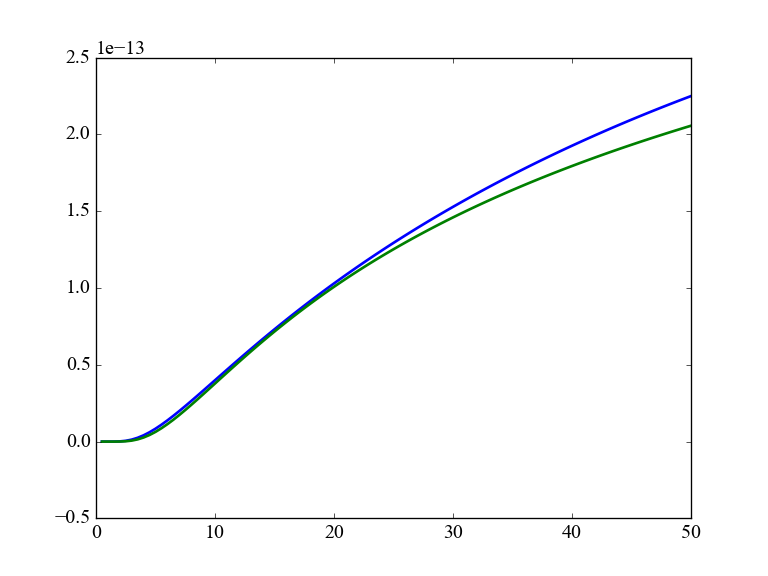

In [11]:
Te       = np.linspace(0.5, 50, 100)

# PASCAL's model
Eion    = 12.127# Ionization energy
E_exc   = 11.6
Estar   = 80    # Crossover energy
h_l     = 0.5

Kexc  = 1.2921e-13*np.exp(-E_exc/Te)
v_the = np.sqrt(8.*phy_const.e*Te/(np.pi*phy_const.m_e))
Kiz   = v_the*(-1.024e-24*Te**2 + 6.386e-20*np.exp(-Eion/Te))  

# Old model
Eion_old    = 12.1  # Ionization energy
Kiz_old = 1.8e-13*(((1.5*Te)/Eion_old)**0.25)*np.exp(- 4*Eion_old/(3*Te))  # Ion - neutral  collision rate          TODO: Replace by better

f, ax = plt.subplots()

ax.plot(Te, Kiz)
ax.plot(Te, Kiz_old)


# Open single file

In [12]:
#####################################
#           Plot variables
#####################################

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

# Save the current
Current[i_save] = J
Voltage[i_save] = V
time[i_save]    = t

<IPython.core.display.Javascript object>


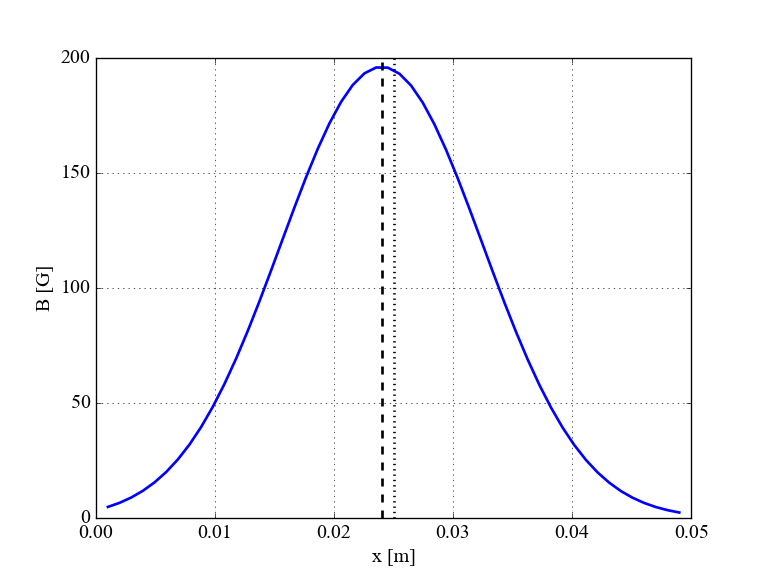

In [13]:
f, ax = plt.subplots()
ax.plot(x_center, B*1e4)
ax.plot(LBMax*np.ones(2), [0,200],'k--')
ax.plot(L0*np.ones(2), [0,200],'k:')
ax.set_ylabel('B [G]')
ax.set_xlabel('x [m]')
ax.grid(True)

<IPython.core.display.Javascript object>


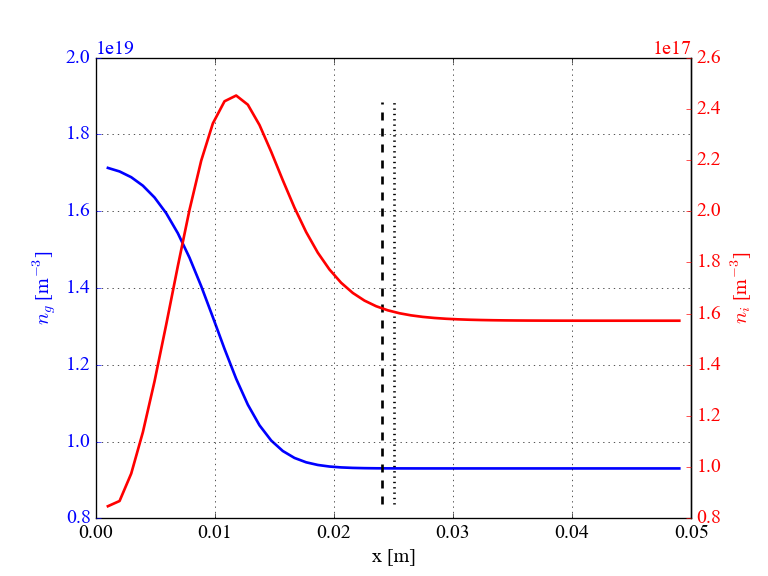

In [14]:
f, ax = plt.subplots()

ax_n_i=ax.twinx()

ax.plot(x_center, P[0,:])

ax.plot(LBMax*np.ones(2), [min(P[0,:])*0.9,max(P[0,:])*1.1],'k--')
ax.plot(L0*np.ones(2), [min(P[0,:])*0.9,max(P[0,:])*1.1],'k:')

ax_n_i.plot(x_center, P[1,:], 'r')

ax_n_i.set_frame_on(True)
ax_n_i.patch.set_visible(False)

plt.setp(ax_n_i.spines.values(), visible=False)
ax_n_i.spines["right"].set_visible(True)



ax.set_ylabel('$n_g$ [m$^{-3}$]')
ax_n_i.set_ylabel('$n_i$ [m$^{-3}$]')

ax.set_xlabel('x [m]')

ax.yaxis.label.set_color('b')
ax.tick_params(axis='y', colors='b')

ax_n_i.yaxis.label.set_color('r')
ax_n_i.tick_params(axis='y', colors='r')

ax.grid(True)

<IPython.core.display.Javascript object>


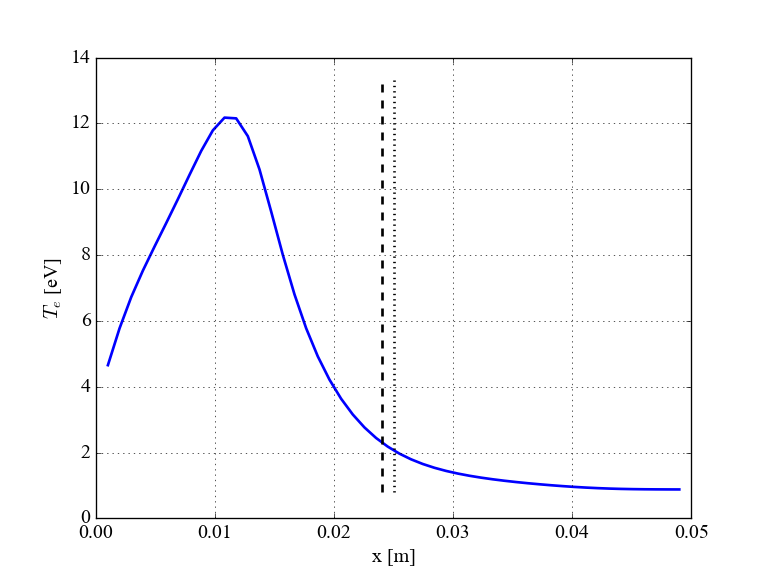

In [15]:
f, ax = plt.subplots()

ax.plot(x_center, P[3,:])

ax.plot(LBMax*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k--')
ax.plot(L0*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k:')


ax.set_ylabel('$T_e$ [eV]')
ax.set_xlabel('x [m]')

ax.grid(True)

<IPython.core.display.Javascript object>


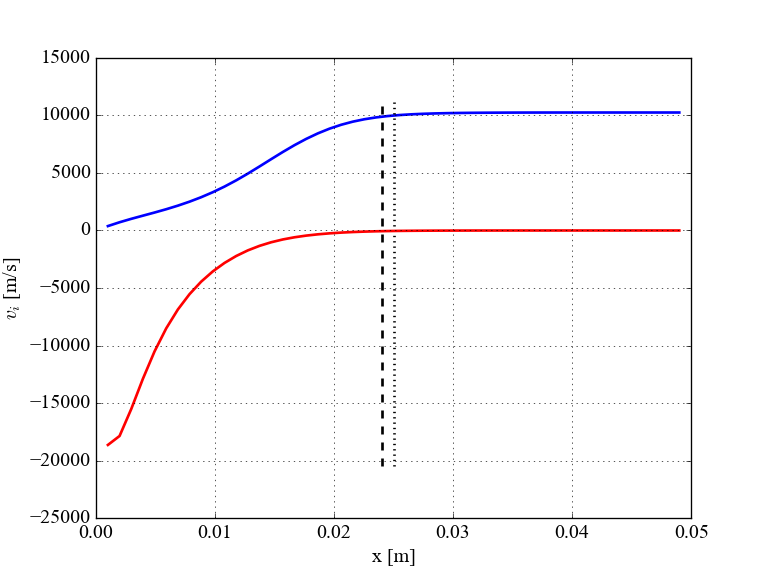

In [16]:
f, ax = plt.subplots()

# ax_v_e=ax.twinx()

ax.plot(x_center, P[2,:])

ax.plot(LBMax*np.ones(2), [min(P[4,:])*1.1,max(P[2,:])*1.1],'k--')
ax.plot(L0*np.ones(2), [min(P[4,:])*1.1,max(P[2,:])*1.1],'k:')

ax.plot(x_center, P[4,:], 'r')

# ax_v_e.set_frame_on(True)
# ax_v_e.patch.set_visible(False)

# plt.setp(ax_v_e.spines.values(), visible=False)
# ax_v_e.spines["right"].set_visible(True)



ax.set_ylabel('$v_i$ [m/s]')
# ax_v_e.set_ylabel('$v_e$ [m/s]')

ax.set_xlabel('x [m]')

# ax_v_e.yaxis.label.set_color('r')
# ax_v_e.tick_params(axis='y', colors='r')

ax.grid(True)

# Comparison

In [431]:
#####################################
#           Plot variables with 50 points
#####################################

RESULTSDIR = './Results/Convergence_50Points/'
ResultsData = RESULTSDIR+"/Data"
configFile  = RESULTSDIR+'/Configuration.cfg'
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

# # Save the current
# Current[i_save] = J
# Voltage[i_save] = V
# time[i_save]    = t

In [432]:
E = compute_E(P,J,B,configFile)
phi = compute_phi(P,J,B,configFile)
np.size(x_center)

Default Magnetic Field
Default Magnetic Field


50

## 100 Cells

In [433]:
#####################################
#           Plot variables with 50 points
#####################################

RESULTSDIR = './Results/Convergence_100Points/'
ResultsData = RESULTSDIR+"/Data"
configFile = RESULTSDIR+'/Configuration.cfg'
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t_100, P_100, U_100, P_Inlet_100, P_Outlet_100, J_100, V_100, B_100, x_center_100] = pickle.load(f)

# # Save the current
# Current[i_save] = J
# Voltage[i_save] = V
# time[i_save]    = t

In [434]:
E_100 = compute_E(P_100,J_100,B_100, configFile)
phi_100 = compute_phi(P_100,J_100,B_100, configFile)
np.size(x_center_100)

Default Magnetic Field
Default Magnetic Field


100

## 200 Point

In [435]:
#####################################
#           Plot variables with 50 points
#####################################

RESULTSDIR = './Results/Convergence_200Points_2/'
ResultsData = RESULTSDIR+"/Data"
configFile = RESULTSDIR+'/Configuration.cfg'
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t_200, P_200, U_200, P_Inlet_200, P_Outlet_200, J_200, V_200, B_200, x_center_200] = pickle.load(f)

# # Save the current
# Current[i_save] = J
# Voltage[i_save] = V
# time[i_save]    = t

In [436]:
E_200 = compute_E(P_200,J_200,B_200,configFile )
phi_200 = compute_phi(P_200,J_200,B_200, configFile)
np.size(x_center_200)

Default Magnetic Field
Default Magnetic Field


200

## 400 Point

In [437]:
#####################################
#           Plot variables with 50 points
#####################################

RESULTSDIR = './Results/Convergence_400Points/'
ResultsData = RESULTSDIR+"/Data"
configFile = RESULTSDIR+'/Configuration.cfg'
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t_400, P_400, U_400, P_Inlet_400, P_Outlet_400, J_400, V_400, B_400, x_center_400] = pickle.load(f)

# Save the current
# Current[i_save] = J
# Voltage[i_save] = V
# time[i_save]    = t

In [438]:
E_400 = compute_E(P_400,J_400,B_400,configFile)
phi_400 = compute_phi(P_400,J_400,B_400,configFile)
np.size(x_center_400)

Default Magnetic Field
Default Magnetic Field


400

## 800 Point

In [439]:
#####################################
#           Plot variables with 50 points
#####################################

RESULTSDIR = './Results/Convergence_800Points/'
ResultsData = RESULTSDIR+"/Data"
configFile = RESULTSDIR+'/Configuration.cfg'
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t_800, P_800, U_800, P_Inlet_800, P_Outlet_800, J_800, V_800, B_800, x_center_800] = pickle.load(f)

# Save the current
# Current[i_save] = J
# Voltage[i_save] = V
# time[i_save]    = t

In [440]:
E_800 = compute_E(P_800,J_800,B_800,configFile)
phi_800 = compute_phi(P_800,J_800,B_800,configFile)
np.size(x_center_800)

Default Magnetic Field
Default Magnetic Field


800

## 1600 Point

In [441]:
#####################################
#           Plot variables with 50 points
#####################################

RESULTSDIR = './Results/Convergence_1600Points/'
ResultsData = RESULTSDIR+"/Data"
configFile = RESULTSDIR+'/Configuration.cfg'
files       = glob.glob(ResultsData + "/*.pkl")
filesSorted = sorted(files, key = lambda x: os.path.getmtime(x), reverse=True)
files.sort(key=os.path.getmtime)

i_save = -1
file = files[i_save]
with open(file, 'rb') as f:
    [t_1600, P_1600, U_1600, P_Inlet_1600, P_Outlet_1600, J_1600, V_1600, B_1600, x_center_1600] = pickle.load(f)

# Save the current
# Current[i_save] = J
# Voltage[i_save] = V
# time[i_save]    = t

In [442]:
E_1600 = compute_E(P_1600,J_1600,B_1600,configFile)
phi_1600 = compute_phi(P_1600,J_1600,B_1600,configFile)
np.size(x_center_1600)

Default Magnetic Field
Default Magnetic Field


1600

In [443]:
with open("Results/Benchmark", 'rb') as f:
        [x_values_bench, Phi_x_bench, E_x_bench, B_bench, n_bench, n_g_bench, vi_bench, v_ex_bench, Te_bench] = pickle.load(f) 
        

In [444]:
import matplotlib
cmap = matplotlib.cm.get_cmap('plasma')
colors = cmap(np.linspace(1,0,6))
colors[0] = cmap(0.9)

In [445]:
# f, ax = plt.subplots()
# ax.plot(x_center, B*1e4)
# ax.plot(LBMax*np.ones(2), [0,200],'k--')
# ax.plot(x_values_bench, B_bench*1e4,":", label="Benchmark")

# ax.plot(L0*np.ones(2), [0,200],'k:')
# ax.set_ylabel('B [G]')
# ax.set_xlabel('x [m]')
# ax.grid(True)

<IPython.core.display.Javascript object>


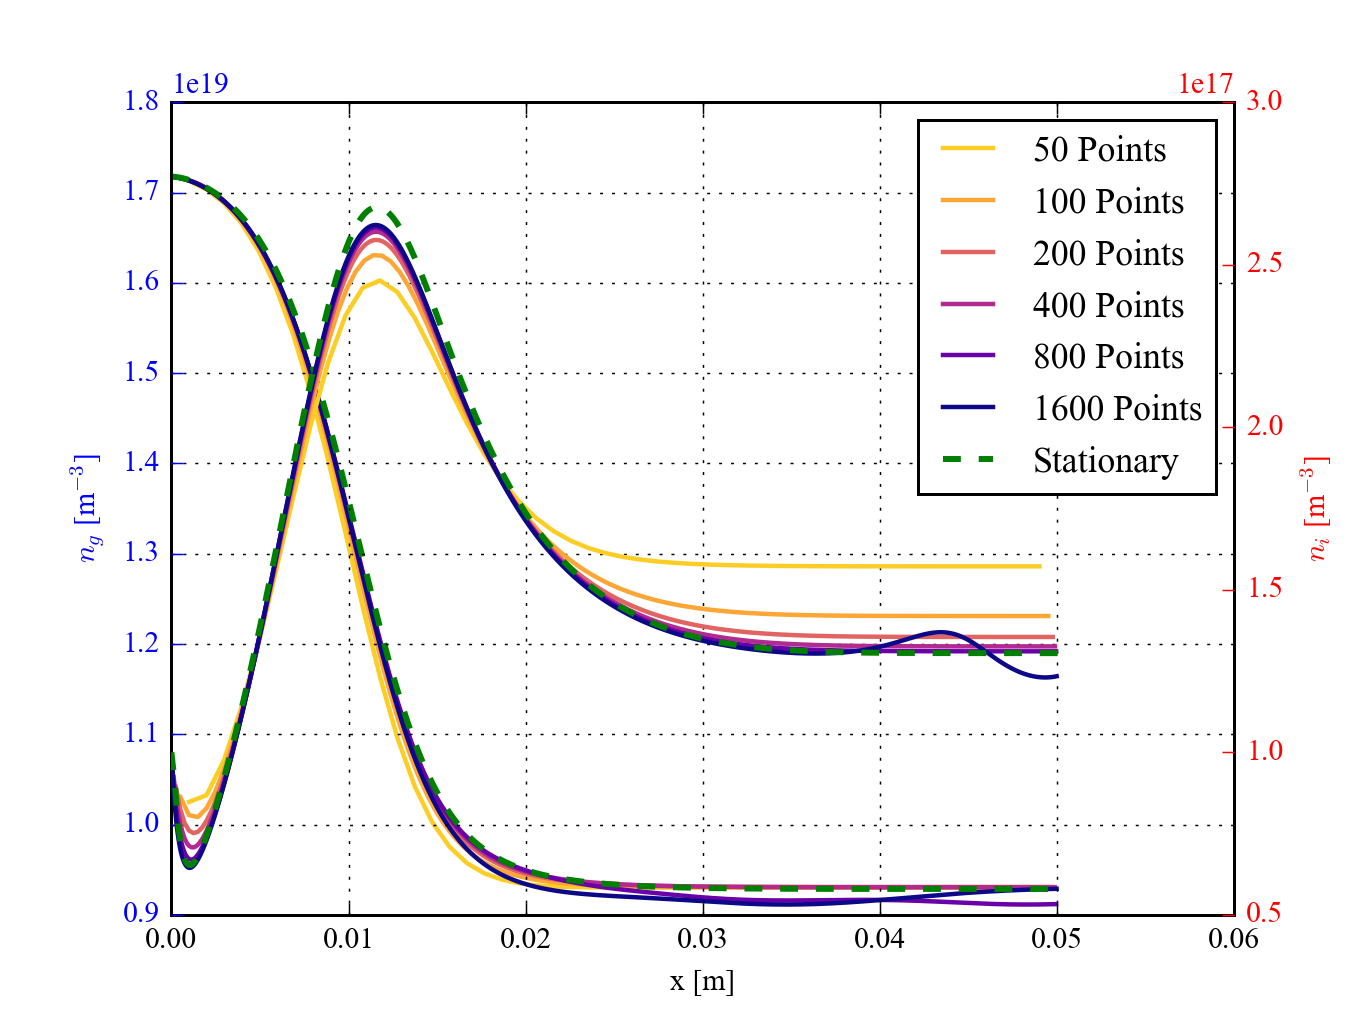

50

In [446]:
f, ax = plt.subplots()

ax_n_i=ax.twinx()

ax.plot(x_center, P[0,:], color=colors[0], label="50 Points",linewidth=1.5)
ax.plot(x_center_100, P_100[0,:], color=colors[1], label="100 Points",linewidth=1.5)
ax.plot(x_center_200, P_200[0,:], color=colors[2], label="200 Points",linewidth=1.5)
ax.plot(x_center_400, P_400[0,:], color=colors[3], label="400 Points",linewidth=1.5)
ax.plot(x_center_800, P_800[0,:], color=colors[4], label="800 Points",linewidth=1.5)
ax.plot(x_center_1600, P_1600[0,:], color=colors[5], label="1600 Points",linewidth=1.5)


ax.plot(x_values_bench, n_g_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)


ax_n_i.plot(x_center, P[1,:], color=colors[0],linewidth=1.5)
ax_n_i.plot(x_center_100, P_100[1,:], color=colors[1],linewidth=1.5)
ax_n_i.plot(x_center_200, P_200[1,:], color=colors[2],linewidth=1.5)
ax_n_i.plot(x_center_400, P_400[1,:], color=colors[3],linewidth=1.5)
ax_n_i.plot(x_center_800, P_800[1,:], color=colors[4],linewidth=1.5)
ax_n_i.plot(x_center_1600, P_1600[1,:], color=colors[5],linewidth=1.5)


ax_n_i.plot(x_values_bench, n_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)

ax_n_i.set_frame_on(True)
ax_n_i.patch.set_visible(False)

plt.setp(ax_n_i.spines.values(), visible=False)
ax_n_i.spines["right"].set_visible(True)


# ax.plot(LBMax*np.ones(2), [min(P[0,:])*0.9,max(P[0,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[0,:])*0.9,max(P[0,:])*1.1],'k:')



ax.set_ylabel('$n_g$ [m$^{-3}$]')
ax_n_i.set_ylabel('$n_i$ [m$^{-3}$]')

ax.set_xlabel('x [m]')

ax.yaxis.label.set_color('b')
ax.tick_params(axis='y', colors='b')

ax_n_i.yaxis.label.set_color('r')
ax_n_i.tick_params(axis='y', colors='r')

ax.grid(True)
ax.legend()
np.size(x_center)

<IPython.core.display.Javascript object>


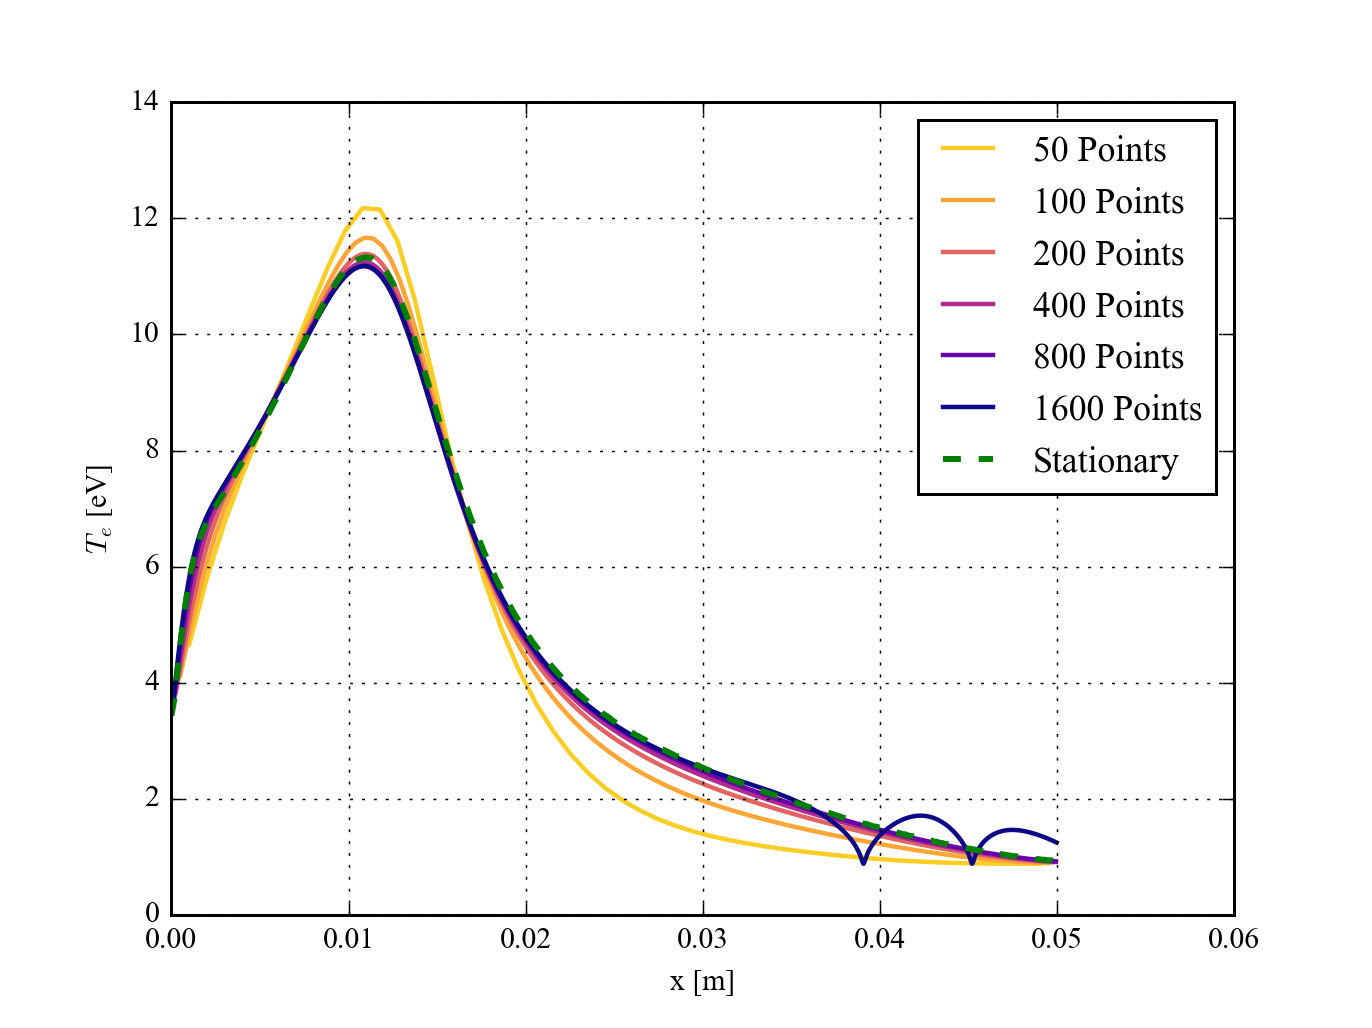

In [447]:
f, ax = plt.subplots()

ax.plot(x_center, P[3,:], color=colors[0],label="50 Points",alpha=1 ,linewidth=1.5)
ax.plot(x_center_100, P_100[3,:], color=colors[1],label="100 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_200, P_200[3,:], color=colors[2],label="200 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_400, P_400[3,:], color=colors[3],label="400 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_800, P_800[3,:], color=colors[4],label="800 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_1600, P_1600[3,:], color=colors[5],label="1600 Points",alpha=1,linewidth=1.5)


ax.plot(x_values_bench, Te_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)

.5
# ax.plot(LBMax*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k:')


ax.set_ylabel('$T_e$ [eV]')
ax.set_xlabel('x [m]')

ax.grid(True)
ax.legend()

<IPython.core.display.Javascript object>


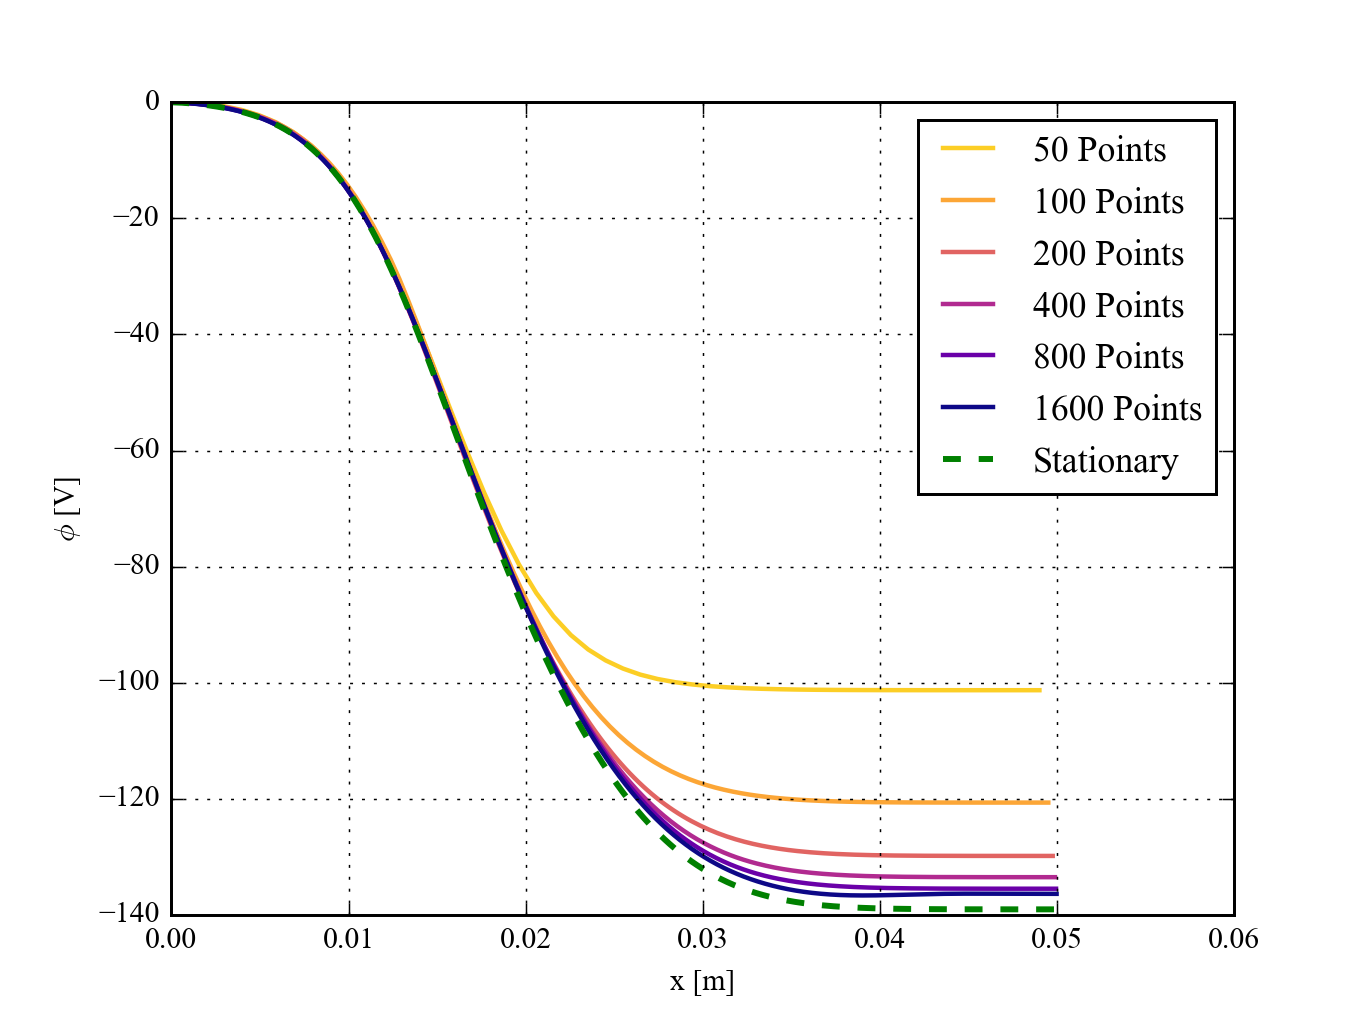

In [448]:
f, ax = plt.subplots()

ax.plot(x_center, phi, color=colors[0],label="50 Points",linewidth=1.5)
ax.plot(x_center_100, phi_100, color=colors[1],label="100 Points",linewidth=1.5)
ax.plot(x_center_200, phi_200, color=colors[2],label="200 Points",linewidth=1.5)
ax.plot(x_center_400, phi_400, color=colors[3],label="400 Points",linewidth=1.5)
ax.plot(x_center_800, phi_800, color=colors[4],label="800 Points",linewidth=1.5)
ax.plot(x_center_1600, phi_1600, color=colors[5],label="1600 Points",linewidth=1.5)


ax.plot(x_values_bench, Phi_x_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)


# ax.plot(LBMax*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k:')


ax.set_ylabel('$\phi$ [V]')
ax.set_xlabel('x [m]')

ax.grid(True)
ax.legend()

<IPython.core.display.Javascript object>


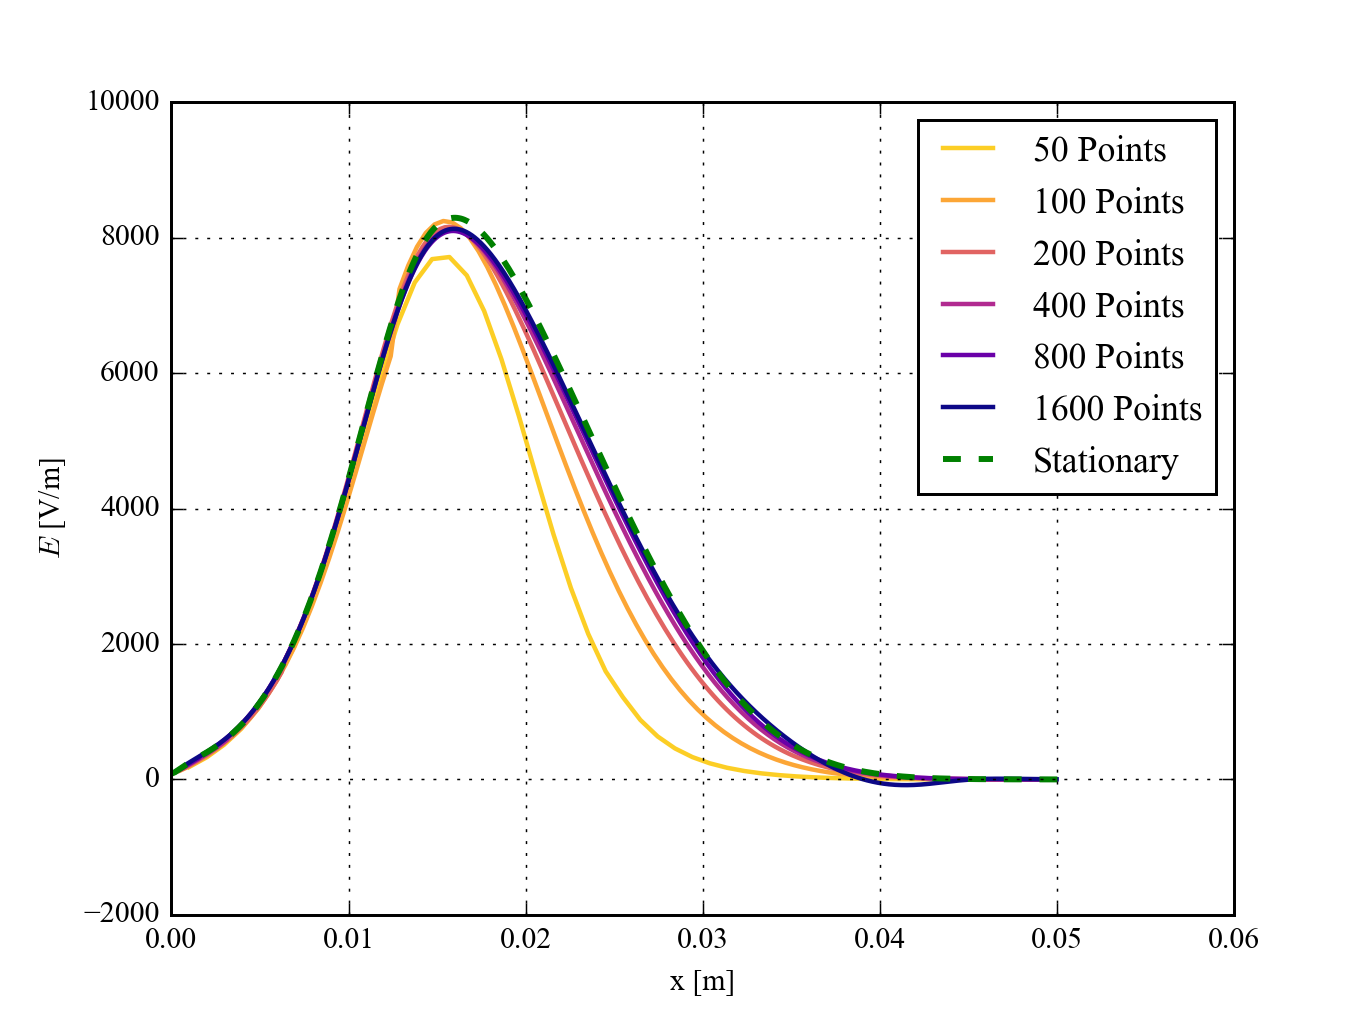

In [449]:
f, ax = plt.subplots()

ax.plot(x_center, E, color=colors[0],label="50 Points",linewidth=1.5)
ax.plot(x_center_100, E_100, color=colors[1],label="100 Points",linewidth=1.5)
ax.plot(x_center_200, E_200, color=colors[2],label="200 Points",linewidth=1.5)
ax.plot(x_center_400, E_400, color=colors[3],label="400 Points",linewidth=1.5)
ax.plot(x_center_800, E_800, color=colors[4],label="800 Points",linewidth=1.5)
ax.plot(x_center_1600, E_1600, color=colors[5],label="1600 Points",linewidth=1.5)

ax.plot(x_values_bench, E_x_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)


# ax.plot(LBMax*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k:')


ax.set_ylabel('$E$ [V/m]')
ax.set_xlabel('x [m]')

ax.grid(True)
ax.legend()

<IPython.core.display.Javascript object>


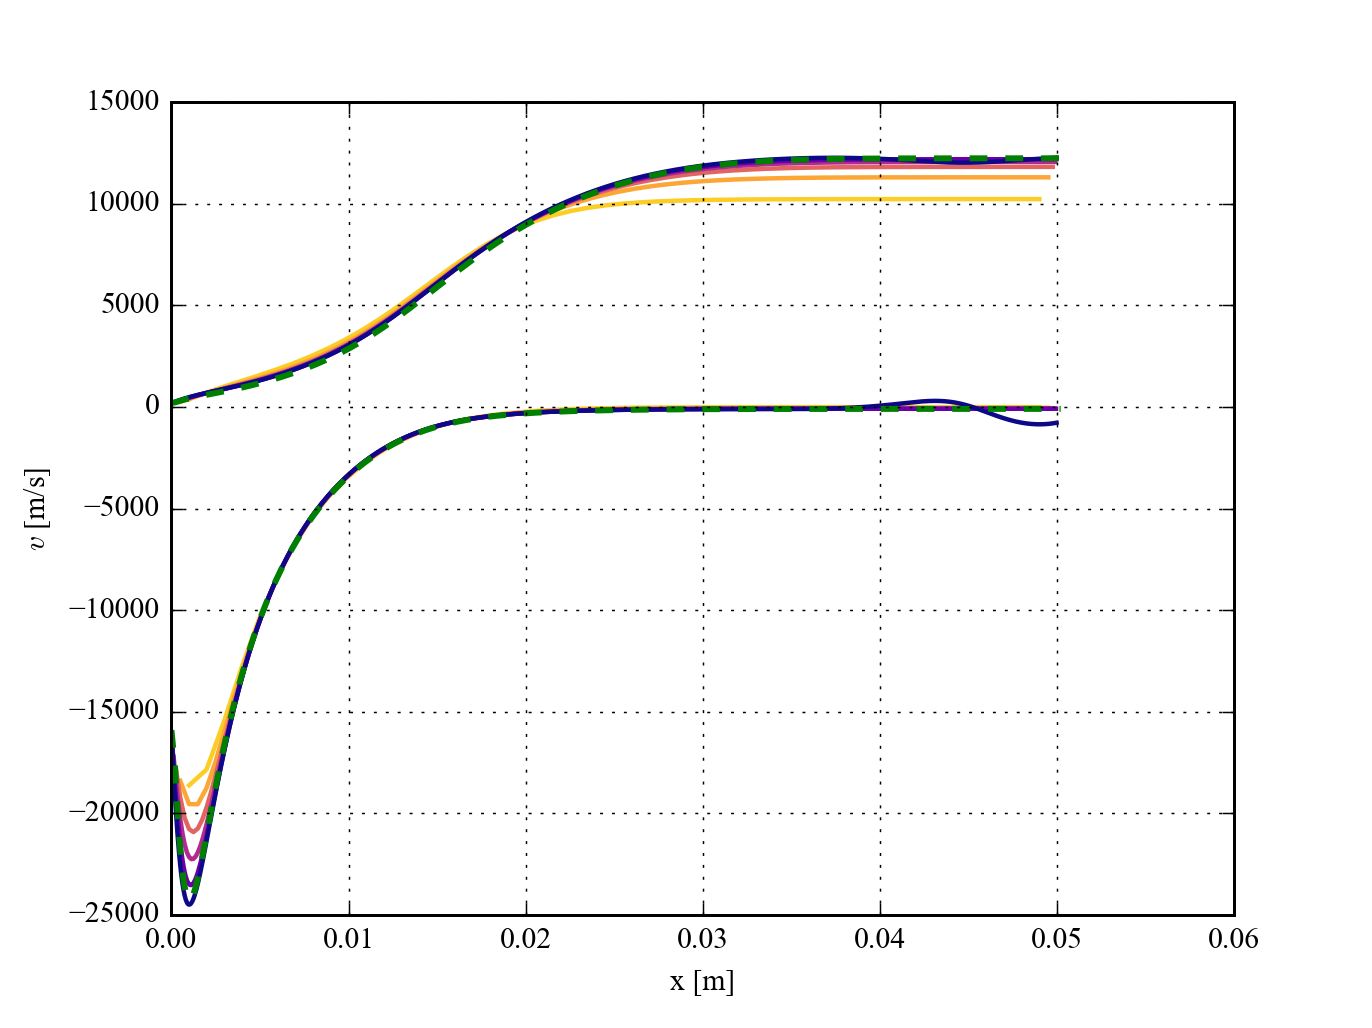

In [450]:
f, ax = plt.subplots()

# ax_v_e=ax.twinx()

ax.plot(x_center, P[2,:], color=colors[0],label="50 Points",alpha=1 ,linewidth=1.5)
ax.plot(x_center_100, P_100[2,:], color=colors[1],label="100 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_200, P_200[2,:], color=colors[2],label="200 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_400, P_400[2,:], color=colors[3],label="400 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_800, P_800[2,:], color=colors[4],label="800 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_1600, P_1600[2,:], color=colors[5],label="1600 Points",alpha=1,linewidth=1.5)
ax.plot(x_values_bench, vi_bench, "--",color="green",label="Stationary",alpha=1, linewidth=2)


# ax.plot(LBMax*np.ones(2), [min(P[4,:])*1.1,max(P[2,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[4,:])*1.1,max(P[2,:])*1.1],'k:')

ax.plot(x_center, P[4,:], color=colors[0],label="50 Points",alpha=1 ,linewidth=1.5)
ax.plot(x_center_100, P_100[4,:], color=colors[1],label="100 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_200, P_200[4,:], color=colors[2],label="200 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_400, P_400[4,:], color=colors[3],label="400 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_800, P_800[4,:], color=colors[4],label="800 Points",alpha=1,linewidth=1.5)
ax.plot(x_center_1600, P_1600[4,:], color=colors[5],label="1600 Points",alpha=1,linewidth=1.5)

ax.plot(x_values_bench, v_ex_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)


# ax_v_e.set_frame_on(True)
# ax_v_e.patch.set_visible(False)

# plt.setp(ax_v_e.spines.values(), visible=False)
# ax_v_e.spines["right"].set_visible(True)



ax.set_ylabel('$v$ [m/s]')
# ax_v_e.set_ylabel('$v_e$ [m/s]')

ax.set_xlabel('x [m]')

# ax_v_e.yaxis.label.set_color('r')
# ax_v_e.tick_params(axis='y', colors='r')

ax.grid(True)

## Computation of error

In [451]:
from scipy import interpolate

# 50 point
NBPOINTS_50 = np.size(P[0,:])
Delta_x_50  = LENGTH/NBPOINTS_50
x_mesh_50   = np.linspace(0, LENGTH, NBPOINTS_50 + 1)                 # Mesh in the interface
x_center_50 = np.linspace(Delta_x_50, LENGTH - Delta_x_50, NBPOINTS_50)     # Mesh in the center of cell

Phi_x_bench_50 = interpolate.interp1d(x_values_bench, Phi_x_bench)
E_x_bench_50   = interpolate.interp1d(x_values_bench, E_x_bench)
n_bench_50     = interpolate.interp1d(x_values_bench, n_bench)
n_g_bench_50   = interpolate.interp1d(x_values_bench, n_g_bench)
vi_bench_50    = interpolate.interp1d(x_values_bench, vi_bench)
v_ex_bench_50  = interpolate.interp1d(x_values_bench, v_ex_bench)
Te_bench_50    = interpolate.interp1d(x_values_bench, Te_bench)

Error_Phi_x_50 = np.abs(phi    - Phi_x_bench_50(x_center_50))
Error_E_x_50   = np.abs(E      - E_x_bench_50(x_center_50))
Error_n_50     = np.abs(P[1,:] - n_bench_50(x_center_50))
Error_n_g_50   = np.abs(P[0,:] - n_g_bench_50(x_center_50))
Error_vi_50    = np.abs(P[2,:] - vi_bench_50(x_center_50))
Error_v_ex_50  = np.abs(P[4,:] - v_ex_bench_50(x_center_50))
Error_Te_50    = np.abs(P[3,:] - Te_bench_50(x_center_50))

Phi_x_50_L2 = np.linalg.norm(Error_Phi_x_50, 2)
E_x_50_L2   = np.linalg.norm(Error_E_x_50, 2)
n_50_L2     = np.linalg.norm(Error_n_50, 2)
n_g_50_L2   = np.linalg.norm(Error_n_g_50, 2)
vi_50_L2    = np.linalg.norm(Error_vi_50, 2)
v_ex_50_L2  = np.linalg.norm(Error_v_ex_50, 2)
Te_50_L2    = np.linalg.norm(Error_Te_50, 2)

# 100 point

NBPOINTS_100 = np.size(P_100[0,:])
Delta_x_100  = LENGTH/NBPOINTS_100
x_mesh_100   = np.linspace(0, LENGTH, NBPOINTS_100 + 1)                 # Mesh in the interface
x_center_100 = np.linspace(Delta_x_100, LENGTH - Delta_x_100, NBPOINTS_100)     # Mesh in the center of cell

Error_Phi_x_100 = np.abs(phi_100    - Phi_x_bench_50(x_center_100))
Error_E_x_100   = np.abs(E_100      - E_x_bench_50(x_center_100))
Error_n_100     = np.abs(P_100[1,:] - n_bench_50(x_center_100))
Error_n_g_100   = np.abs(P_100[0,:] - n_g_bench_50(x_center_100))
Error_vi_100    = np.abs(P_100[2,:] - vi_bench_50(x_center_100))
Error_v_ex_100  = np.abs(P_100[4,:] - v_ex_bench_50(x_center_100))
Error_Te_100    = np.abs(P_100[3,:] - Te_bench_50(x_center_100))

Phi_x_100_L2 = np.linalg.norm(Error_Phi_x_100, 2)
E_x_100_L2   = np.linalg.norm(Error_E_x_100, 2)
n_100_L2     = np.linalg.norm(Error_n_100, 2)
n_g_100_L2   = np.linalg.norm(Error_n_g_100, 2)
vi_100_L2    = np.linalg.norm(Error_vi_100, 2)
v_ex_100_L2  = np.linalg.norm(Error_v_ex_100, 2)
Te_100_L2    = np.linalg.norm(Error_Te_100, 2)



# 200 point

NBPOINTS_200 = np.size(P_200[0,:])
Delta_x_200  = LENGTH/NBPOINTS_200
x_mesh_200   = np.linspace(0, LENGTH, NBPOINTS_200 + 1)                 # Mesh in the interface
x_center_200 = np.linspace(Delta_x_200, LENGTH - Delta_x_200, NBPOINTS_200)     # Mesh in the center of cell

Error_Phi_x_200 = np.abs(phi_200    - Phi_x_bench_50(x_center_200))
Error_E_x_200   = np.abs(E_200      - E_x_bench_50(x_center_200))
Error_n_200     = np.abs(P_200[1,:] - n_bench_50(x_center_200))
Error_n_g_200   = np.abs(P_200[0,:] - n_g_bench_50(x_center_200))
Error_vi_200    = np.abs(P_200[2,:] - vi_bench_50(x_center_200))
Error_v_ex_200  = np.abs(P_200[4,:] - v_ex_bench_50(x_center_200))
Error_Te_200    = np.abs(P_200[3,:] - Te_bench_50(x_center_200))

Phi_x_200_L2 = np.linalg.norm(Error_Phi_x_200, 2)
E_x_200_L2   = np.linalg.norm(Error_E_x_200, 2)
n_200_L2     = np.linalg.norm(Error_n_200, 2)
n_g_200_L2   = np.linalg.norm(Error_n_g_200, 2)
vi_200_L2    = np.linalg.norm(Error_vi_200, 2)
v_ex_200_L2  = np.linalg.norm(Error_v_ex_200, 2)
Te_200_L2    = np.linalg.norm(Error_Te_200, 2)



# 400 point

NBPOINTS_400 = np.size(P_400[0,:])
Delta_x_400  = LENGTH/NBPOINTS_400
x_mesh_400   = np.linspace(0, LENGTH, NBPOINTS_400 + 1)                 # Mesh in the interface
x_center_400 = np.linspace(Delta_x_400, LENGTH - Delta_x_400, NBPOINTS_400)     # Mesh in the center of cell

Error_Phi_x_400 = np.abs(phi_400    - Phi_x_bench_50(x_center_400))
Error_E_x_400   = np.abs(E_400      - E_x_bench_50(x_center_400))
Error_n_400     = np.abs(P_400[1,:] - n_bench_50(x_center_400))
Error_n_g_400   = np.abs(P_400[0,:] - n_g_bench_50(x_center_400))
Error_vi_400    = np.abs(P_400[2,:] - vi_bench_50(x_center_400))
Error_v_ex_400  = np.abs(P_400[4,:] - v_ex_bench_50(x_center_400))
Error_Te_400    = np.abs(P_400[3,:] - Te_bench_50(x_center_400))

Phi_x_400_L2 = np.linalg.norm(Error_Phi_x_400, 2)
E_x_400_L2   = np.linalg.norm(Error_E_x_400, 2)
n_400_L2     = np.linalg.norm(Error_n_400, 2)
n_g_400_L2   = np.linalg.norm(Error_n_g_400, 2)
vi_400_L2    = np.linalg.norm(Error_vi_400, 2)
v_ex_400_L2  = np.linalg.norm(Error_v_ex_400, 2)
Te_400_L2    = np.linalg.norm(Error_Te_400, 2)

# 800 point

NBPOINTS_800 = np.size(P_800[0,:])
Delta_x_800  = LENGTH/NBPOINTS_800
x_mesh_800   = np.linspace(0, LENGTH, NBPOINTS_800 + 1)                 # Mesh in the interface
x_center_800 = np.linspace(Delta_x_800, LENGTH - Delta_x_800, NBPOINTS_800)     # Mesh in the center of cell

Error_Phi_x_800 = np.abs(phi_800    - Phi_x_bench_50(x_center_800))
Error_E_x_800   = np.abs(E_800      - E_x_bench_50(x_center_800))
Error_n_800     = np.abs(P_800[1,:] - n_bench_50(x_center_800))
Error_n_g_800   = np.abs(P_800[0,:] - n_g_bench_50(x_center_800))
Error_vi_800    = np.abs(P_800[2,:] - vi_bench_50(x_center_800))
Error_v_ex_800  = np.abs(P_800[4,:] - v_ex_bench_50(x_center_800))
Error_Te_800    = np.abs(P_800[3,:] - Te_bench_50(x_center_800))

Phi_x_800_L2 = np.linalg.norm(Error_Phi_x_800, 2)
E_x_800_L2   = np.linalg.norm(Error_E_x_800, 2)
n_800_L2     = np.linalg.norm(Error_n_800, 2)
n_g_800_L2   = np.linalg.norm(Error_n_g_800, 2)
vi_800_L2    = np.linalg.norm(Error_vi_800, 2)
v_ex_800_L2  = np.linalg.norm(Error_v_ex_800, 2)
Te_800_L2    = np.linalg.norm(Error_Te_800, 2)


# 1600 point

NBPOINTS_1600 = np.size(P_1600[0,:])
Delta_x_1600  = LENGTH/NBPOINTS_1600
x_mesh_1600   = np.linspace(0, LENGTH, NBPOINTS_1600 + 1)                 # Mesh in the interface
x_center_1600 = np.linspace(Delta_x_1600, LENGTH - Delta_x_1600, NBPOINTS_1600)     # Mesh in the center of cell

Error_Phi_x_1600 = np.abs(phi_1600    - Phi_x_bench_50(x_center_1600))
Error_E_x_1600   = np.abs(E_1600      - E_x_bench_50(x_center_1600))
Error_n_1600     = np.abs(P_1600[1,:] - n_bench_50(x_center_1600))
Error_n_g_1600   = np.abs(P_1600[0,:] - n_g_bench_50(x_center_1600))
Error_vi_1600    = np.abs(P_1600[2,:] - vi_bench_50(x_center_1600))
Error_v_ex_1600  = np.abs(P_1600[4,:] - v_ex_bench_50(x_center_1600))
Error_Te_1600    = np.abs(P_1600[3,:] - Te_bench_50(x_center_1600))

Phi_x_1600_L2 = np.linalg.norm(Error_Phi_x_1600, 2)
E_x_1600_L2   = np.linalg.norm(Error_E_x_1600, 2)
n_1600_L2     = np.linalg.norm(Error_n_1600, 2)
n_g_1600_L2   = np.linalg.norm(Error_n_g_1600, 2)
vi_1600_L2    = np.linalg.norm(Error_vi_1600, 2)
v_ex_1600_L2  = np.linalg.norm(Error_v_ex_1600, 2)
Te_1600_L2    = np.linalg.norm(Error_Te_1600, 2)



### L2-Norm

<IPython.core.display.Javascript object>


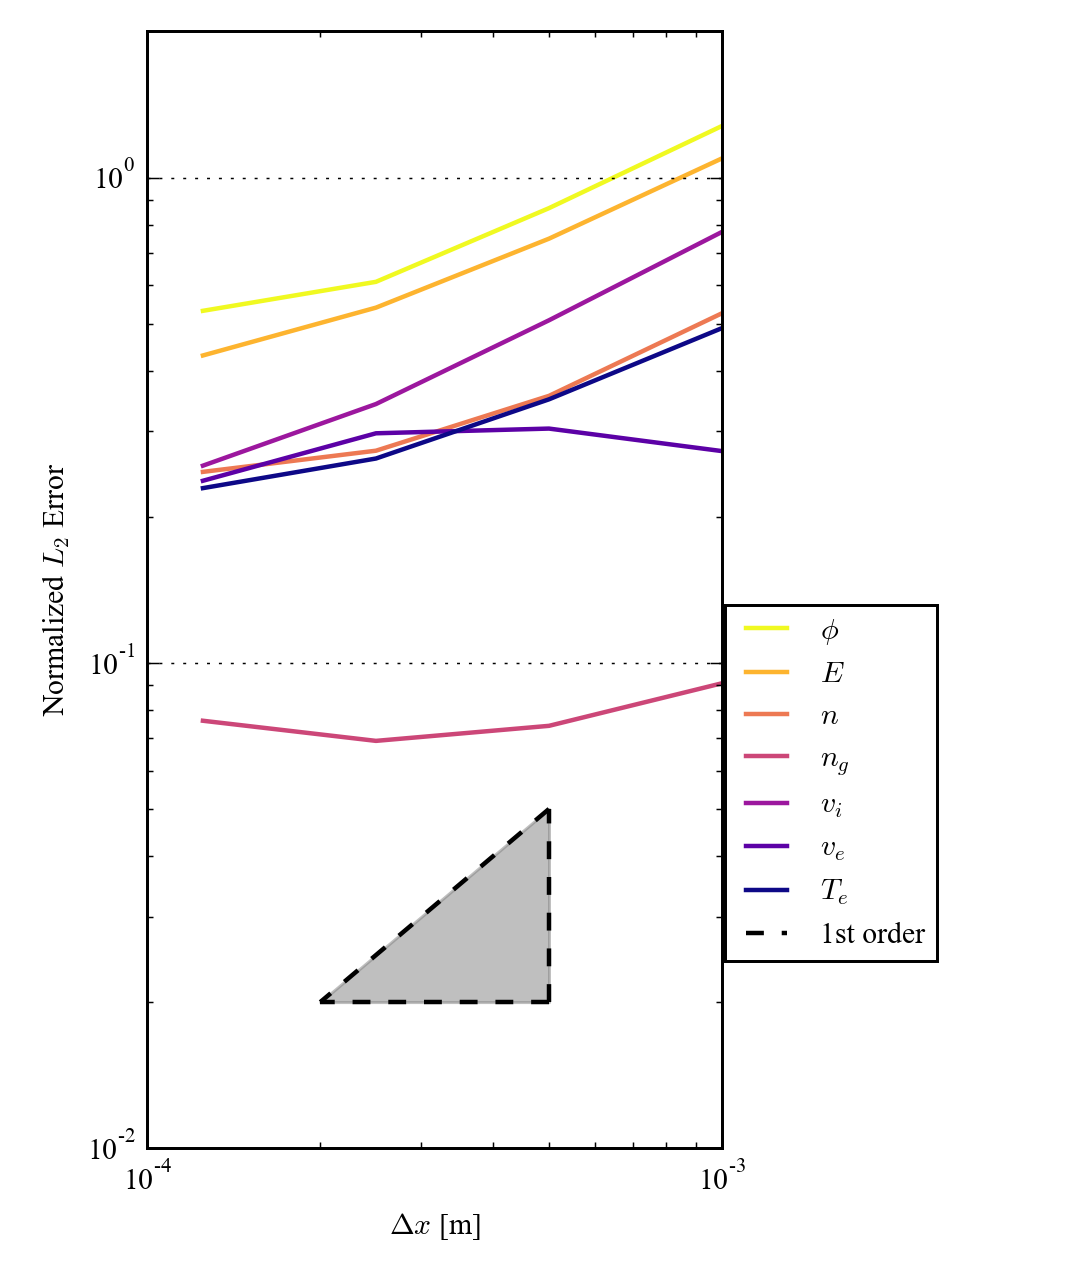

In [452]:
cmap = matplotlib.cm.get_cmap('plasma')
colors_error = cmap(np.linspace(1,0,7))
# colors[0] = cmap(0.9)

Dx_array     = [Delta_x_50,Delta_x_100, Delta_x_200, Delta_x_400]#, Delta_x_800, Delta_x_1600]
Phi_L2_array = [Phi_x_50_L2, Phi_x_100_L2, Phi_x_200_L2, Phi_x_400_L2]#, Phi_x_800_L2, Phi_x_1600_L2]
E_L2_array   = [E_x_50_L2, E_x_100_L2, E_x_200_L2, E_x_400_L2]#, E_x_800_L2, E_x_1600_L2]
n_L2_array   = [n_50_L2, n_100_L2, n_200_L2, n_400_L2]#, n_800_L2, n_1600_L2]
ng_L2_array  = [n_g_50_L2, n_g_100_L2, n_g_200_L2, n_g_400_L2]#, n_g_800_L2, n_g_1600_L2]
vi_L2_array  = [vi_50_L2, vi_100_L2, vi_200_L2, vi_400_L2]#, vi_800_L2, vi_1600_L2]
v_ex_L2_array = [v_ex_50_L2, v_ex_100_L2, v_ex_200_L2, v_ex_400_L2]#, v_ex_800_L2, v_ex_1600_L2]
Te_L2_array  = [Te_50_L2, Te_100_L2, Te_200_L2, Te_400_L2]#, Te_800_L2, Te_1600_L2]


f, ax = plt.subplots(figsize=(5, 6))

ax.plot(Dx_array, Phi_L2_array/np.max(np.abs(Phi_x_bench)), color=colors_error[0],label="$\phi$",linewidth=1.5)
ax.plot(Dx_array, E_L2_array/np.max(np.abs(E_x_bench)), color=colors_error[1],label="$E$",linewidth=1.5)
ax.plot(Dx_array, n_L2_array/np.max(np.abs(n_bench)), color=colors_error[2],label="$n$",linewidth=1.5)
ax.plot(Dx_array, ng_L2_array/np.max(np.abs(n_g_bench)), color=colors_error[3],label="$n_g$",linewidth=1.5)
ax.plot(Dx_array, vi_L2_array/np.max(np.abs(vi_bench)), color=colors_error[4],label="$v_i$",linewidth=1.5)
ax.plot(Dx_array, v_ex_L2_array/np.max(np.abs(v_ex_bench)), color=colors_error[5],label="$v_e$",linewidth=1.5)
ax.plot(Dx_array, Te_L2_array/np.max(np.abs(Te_bench)), color=colors_error[6],label="$T_e$",linewidth=1.5)

slope = interpolate.interp1d([1e-3, 1e-4], [1e-1, 1e-2])

ax.plot([5e-4, 2e-4], slope([5e-4, 2e-4]) , 'k--',label="1st order",linewidth=1.5)
ax.plot([5e-4, 2e-4], [slope(2e-4),slope(2e-4)]  , 'k--',linewidth=1.5)
ax.plot([5e-4, 5e-4], [slope(2e-4),slope(5e-4)]  , 'k--',linewidth=1.5)
ax.fill_between([5e-4, 2e-4], slope([5e-4, 2e-4]),slope(2e-4), color='gray', alpha = 0.5)


# ax.plot(x_values_bench, Phi_x_bench, "--", color="green",label="Stationary",alpha=1, linewidth=2)


# ax.plot(LBMax*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[3,:])*0.9,max(P[3,:])*1.1],'k:')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-4,1e-3])
ax.set_ylim([1e-2,2])

ax.legend(bbox_to_anchor=(1.4, 0.5), fontsize=10)

ax.set_ylabel('Normalized $L_2$ Error')
ax.set_xlabel('$\\Delta x $ [m]')

ax.grid(True)
plt.tight_layout()


<IPython.core.display.Javascript object>


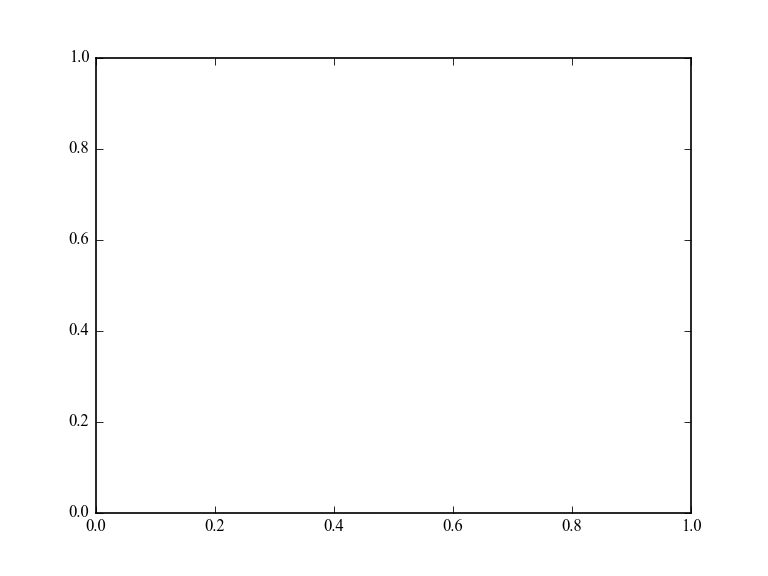

NameError: name 'A0' is not defined

In [259]:
f, ax = plt.subplots()

# ax_v_e=ax.twinx()

ax.plot(x_center, P[1,:]*(P[2,:]-P[4,:])*phy_const.e*A0)
ax.plot(x_values_bench, n_bench*(vi_bench - v_ex_bench)*phy_const.e*A0, "--", label="Stationnary")


# ax.plot(LBMax*np.ones(2), [min(P[4,:])*1.1,max(P[2,:])*1.1],'k--')
# ax.plot(L0*np.ones(2), [min(P[4,:])*1.1,max(P[2,:])*1.1],'k:')

# ax.plot(x_center, P[4,:], 'r')
# ax.plot(x_values_bench, v_ex_bench, "--", label="Stationnary")


# ax_v_e.set_frame_on(True)
# ax_v_e.patch.set_visible(False)

# plt.setp(ax_v_e.spines.values(), visible=False)
# ax_v_e.spines["right"].set_visible(True)



ax.set_ylabel('Current [A]')
# ax_v_e.set_ylabel('$v_e$ [m/s]')

ax.set_xlabel('x [m]')

# ax_v_e.yaxis.label.set_color('r')
# ax_v_e.tick_params(axis='y', colors='r')

ax.grid(True)

<IPython.core.display.Javascript object>


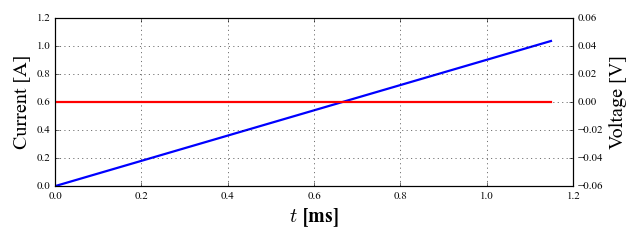

Preparing plot for i =  0


NameError: name 'PLOT_VARS' is not defined

In [26]:
#####################################
#           Plot current
#####################################

f, ax = plt.subplots(figsize=(8,3))

ax.plot(time/1e-3, Current)
ax.set_xlabel(r'$t$ [ms]', fontsize=18, weight = 'bold')
ax.set_ylabel(r'Current [A]', fontsize=18)
ax_V=ax.twinx()
ax_V.plot(time/1e-3, Voltage,'r')
ax_V.set_ylabel(r'Voltage [V]', fontsize=18)
ax.grid(True)
plt.tight_layout()
plt.savefig(ResultsFigs+"/Current.pdf", bbox_inches='tight')
    
for i_save, file in enumerate(files):

    print("Preparing plot for i = ", i_save)
    #
    with open(file, 'rb') as f:
        [t, P, U, P_Inlet, P_Outlet, J, V, B, x_center] = pickle.load(f)

    if PLOT_VARS:
        E = compute_E(P,J)
        phi = compute_phi(P,J)
        
#        f, ax = plt.subplots(5, 1, figsize = (5,8))
#
#        ax_b=ax[0].twinx()
#        ax[0].plot(x_center, P[0,:], color=(255/255,97/255,3/255), linewidth=1.8, markersize=3)
#        ax_b.plot(x_center, B, ':', color=(0,128./255.,0.), linewidth=0.9, markersize=3)
#        ax_b.set_yticks([0, max(B)])
#        ax_b.set_ylabel(r'$B$ [T]', color=(0,128./255.,0.))
#        ax[0].set_ylabel(r'$n_g$ [m$^{-3}$]', fontsize=18)
#        ax[0].set_xticklabels([])
#        ax[0].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
#        ax[0].legend(loc = 'lower center', fontsize = 12)
#        ax[0].set_ylim([0,max(P[0,:])*1.1])
#
#        ax_b=ax[1].twinx()
#        ax[1].plot(x_center, P[1,:], color=(255/255,97/255,3/255), linewidth=1.8, markersize=3)
#        ax_b.plot(x_center, B, ':', color=(0,128./255.,0.), linewidth=0.9, markersize=3)
#        ax_b.set_yticklabels([])
#        #ax[1].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
#        ax[1].set_ylabel(r'$n_i$ [m$^{-3}$]', fontsize=18)
#        #ax[1].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
#        ax[1].set_xticklabels([])
#        ax[1].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
#        max_ni = 1e17
#        if max(P[1,:]) > 1e18:
#            max_ni = max(P[1,:])*1.5
#        elif max(P[1,:]) > 1e17:
#            max_ni = 1e18
#        else:
#            max_ni = 1e17
#        ax[1].set_ylim([0, max_ni])
#
#        ax_b=ax[2].twinx()
#        ax[2].plot(x_center, P[2,:]/1000, color=(255/255,97/255,3/255), linewidth=1.8, markersize=3)
#        ax_b.plot(x_center, B, ':', color=(0,128./255.,0.), linewidth=0.9, markersize=3)
#        ax_b.set_yticklabels([])
#        #ax[2].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
#        ax[2].set_ylabel(r'$v_i$ [km/s]', fontsize=18)
#        #ax[2].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
#        ax[2].set_xticklabels([])
#        ax[2].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
#        ax[2].legend(loc = 'lower center', fontsize = 12)
#
#        ax_b=ax[3].twinx()
#        ax[3].plot(x_center, P[3,:], color=(255/255,97/255,3/255), linewidth=1.8, markersize=3)
#        ax_b.plot(x_center, B, ':', color=(0,128./255.,0.), linewidth=0.9, markersize=3)
#        ax_b.set_yticklabels([])
#        #ax[3].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
#        ax[3].set_ylabel(r'$T_e$ [eV]', fontsize=18)
#        #ax[3].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
#        ax[3].set_xticklabels([])
#        ax[3].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
#        ax[3].legend(loc = 'lower center', fontsize = 12)
#        f.suptitle('t = ', fontname = 'Times New Roman',fontsize=16, weight = 'bold')
#
#        ax[4].plot(x_center*100, P[4,:]/1000., color=(255/255,97/255,3/255), linewidth=1.8, markersize=3)
#        ax[4].set_xlabel(r'$x~[cm]$', fontsize=18, weight = 'bold')
#        ax[4].set_ylabel(r'$v_e$ [km/s]', fontsize=18)
#        ax[4].xaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
#        ax[4].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
#        ax[4].legend(loc = 'lower center', fontsize = 12)
#        title = 'time = '+ str(round(t/1e-6, 4))+'$\mu$s'
#        plt.suptitle(title, y=1.05)
#
#        for axis in ax:
#            axis.grid(True)
#        plt.tight_layout()
#
#        plt.subplots_adjust(hspace=0.1)
#        plt.savefig(ResultsFigs+"/MacroscopicVars_"+str(i_save)+".png", bbox_inches='tight')
#        plt.close()
#
#
        
        f = plt.subplots(figsize = (8,7))

        ax1 = plt.subplot(4,2,1)
        ax2 = plt.subplot(4,2,2)
        ax3 = plt.subplot(4,2,3)
        ax4 = plt.subplot(4,2,4)
        ax5 = plt.subplot(4,2,5)
        ax6 = plt.subplot(4,2,6)
        ax7 = plt.subplot(4,1,4)

        ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]

        ax_b=ax[0].twinx()
        ax[0].plot(x_center, P[0,:], linewidth=1.8, markersize=3)
        ax_b.plot(x_center, B, 'r:', linewidth=0.9, markersize=3)
        ax_b.set_yticks([0, max(B)])
        #ax_b.set_ylabel(r'$B$ [T]', color='r')
        #ax[0].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
        ax[0].set_ylabel(r'$n_g$ [m$^{-3}$]', fontsize=18)
        #ax[0].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
        ax[0].set_xticklabels([])
        ax[0].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        #ax[0].legend(loc = 'lower center', fontsize = 12)
        ax[0].set_ylim([0,max(P[0,:])*1.1])

        ax_phi=ax[1].twinx()
        ax[1].plot(x_center*100, E, linewidth=1.8, markersize=3)
        ax_phi.plot(x_center*100, phi, color='r', linewidth=1.8, markersize=3)
        ax_phi.set_ylabel(r'$V$ [V]', color='r')
        ax[1].set_ylabel(r'$E$ [V/m]', fontsize=18)
        ax[1].set_xticklabels([])
        ax[1].xaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        ax[1].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)

        ax_b=ax[2].twinx()
        ax[2].plot(x_center, P[1,:], linewidth=1.8, markersize=3)
        ax_b.plot(x_center, B, 'r:', linewidth=0.7, markersize=3)
        ax_b.set_yticklabels([])
        #ax[2].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
        ax[2].set_ylabel(r'$n_i$ [m$^{-3}$]', fontsize=18)
        #ax[2].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
        ax[2].set_xticklabels([])
        ax[2].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        #ax[1].legend(loc = 'lower center', fontsize = 12)
        
        max_ni = 1e17
        if max(P[1,:]) > 1e18:
            max_ni = max(P[1,:])*1.5
        elif max(P[1,:]) > 1e17:
            max_ni = 1e18
        else:
            max_ni = 1e17
            
        ax[2].set_ylim([0, max_ni])
        
        ax_b=ax[3].twinx()
        ax[3].plot(x_center, P[3,:], linewidth=1.8, markersize=3)
        ax_b.plot(x_center, B, 'r:', linewidth=0.7, markersize=3)
        ax_b.set_yticklabels([])
        #ax[3].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
        ax[3].set_ylabel(r'$T_e$ [eV]', fontsize=18)
        #ax[3].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
        ax[3].set_xticklabels([])
        ax[3].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        #ax[3].legend(loc = 'lower center', fontsize = 12)
        #f.suptitle('t = ', fontname = 'Times New Roman',fontsize=16, weight = 'bold')

        ax_b=ax[4].twinx()
        ax[4].plot(x_center*100, P[2,:]/1000, linewidth=1.8, markersize=3)
        ax[4].plot(x_center*100, np.sqrt(phy_const.e*P[3,:]/(131.293*phy_const.m_u))/1000.,'g--', linewidth=1.8, markersize=3)
        ax_b.plot(x_center, B, 'r:', linewidth=0.7, markersize=3)
        ax_b.set_yticklabels([])
        #ax[4].set_xlabel(r'$x~[m]$', fontsize=18, weight = 'bold')
        ax[4].set_ylabel(r'$v_i$ [km/s]', fontsize=18)
        ax[4].set_xlabel(r'$x~[cm]$', fontsize=18, weight = 'bold')
        #ax[4].xaxis.set_tick_params(which='both', size=0, width=1.5, labelsize=0)
        #ax[4].set_xticklabels([])
        #ax[4].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        ax[4].legend(loc = 'lower center', fontsize = 12)

        ax[5].plot(x_center*100, P[4,:]/1000, linewidth=1.8, markersize=3)
        ax[5].set_xlabel(r'$x~[cm]$', fontsize=18, weight = 'bold')
        ax[5].set_ylabel(r'$v_e$ [km/s]', fontsize=18)
        ax[5].xaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        ax[5].yaxis.set_tick_params(which='both', size=5, width=1.5, labelsize=13)
        #ax[4].legend(loc = 'lower center', fontsize = 12)
        title = 'time = '+ str(round(t/1e-6, 4))+'$\mu$s'
        f[0].suptitle(title, y=1.05)

        ax[6].plot(time/1e-3, Current)
        ax[6].set_ylabel(r'Current [A]', fontsize=18)
        ax[6].set_xlabel(r'time [ms]', fontsize=18)
        ax[6].plot(time[i_save]/1e-3, Current[i_save], 'ro', markersize=10)
        ax[6].grid(True)
        ax[6].set_xlim([0,3.])

        for axis in ax:
            axis.grid(True)
            #axis.get_legend().remove()
            
        ax[0].legend(fontsize = 10, loc='lower right')
        plt.tight_layout()

        plt.subplots_adjust(wspace = 0.4, hspace=0.2)
        
        plt.savefig(ResultsFigs+"/MacroscopicVars_New_"+str(i_save)+".png", bbox_inches='tight')
        plt.close()
    

os.system("ffmpeg -r 10 -i "+ResultsFigs+"/MacroscopicVars_New_%d.png -vcodec mpeg4 -y -vb 20M "+ResultsFigs+"Evolution.mp4")

